**Le lien vers le dataset:**
https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

**ou bien : https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php**

####Importing the necessary libraries

In [2]:
#Visualisation and algebra libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

# Additional Libs for ML
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

#maching learning models to use
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

#Nlp libraries
import nltk
from nltk import pos_tag
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re,string
from nltk.corpus import stopwords

#import pickle to save the ML model with the highest accuracy
import pickle

####Data overview

In [70]:
data=pd.read_csv("final_data (1).csv")
#On supprime la colonne des anciennes index
data.drop("Unnamed: 0",axis=1,inplace=True)

#rename the target column into label
data=data.rename(columns={"fake":"label"})

#replace 0 with real and 1 with fake
data["label"]=data["label"].replace([0,1],["real","fake"])

#les 5 premieres exemples
data.head()

,title,text,subject,date,label
0,China warns against livestreaming after 'rooft...,BEIJING (Reuters) - A young Chinese climbing e...,worldnews,"December 12, 2017",real
1,LOL! HIGH SCHOOL STUDENTS Skip School To Prote...,,left-news,"Feb 12, 2017",fake
2,BREAKING: GANG THAT CAN’T SHOOT STRAIGHT: Vote...,Speaker Ryan: We were on the cusp of achievin...,politics,"Mar 24, 2017",fake
3,"Arab states blacklist Islamist groups, individ...",DUBAI (Reuters) - The four Arab countries boyc...,worldnews,"November 22, 2017",real
4,"Democrats to join Trump, Republicans in talks ...",WASHINGTON (Reuters) - Democratic leaders in C...,politicsNews,"December 4, 2017",real


In [71]:
#Le nombre d'exemple et des variables
print(f"\tLe nombre des exemples est: {data.shape[0]} et le nombre de colonnes est: {data.shape[1]}")

	Le nombre des exemples est: 44898 et le nombre de colonnes est: 5


In [72]:
data.drop_duplicates(inplace=True)
print(f"\tLe nombre des exemples est: {data.shape[0]} et le nombre de colonnes est: {data.shape[1]}")

	Le nombre des exemples est: 44689 et le nombre de colonnes est: 5


--> there was some duplicated values

In [73]:
data.loc[data["text"]==" "]

,title,text,subject,date,label
1,LOL! HIGH SCHOOL STUDENTS Skip School To Prote...,,left-news,"Feb 12, 2017",fake
29,WOW! WHITE Liberals Suggest Blacks Are Too Stu...,,politics,"Nov 15, 2016",fake
71,DR MARTIN LUTHER KING’S NIECE: “I believe that...,,politics,"Jan 16, 2017",fake
304,AMAZING ENTRANCE! Trump Does “Les Deplorables”...,,politics,"Sep 16, 2016",fake
504,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,politics,"Apr 25, 2015",fake
...,...,...,...,...,...
44469,OUTRAGEOUS! NANCY PELOSI Claims Obamacare Hono...,,Government News,"Mar 25, 2017",fake
44509,NEW EVIDENCE PROVES Hillary Manipulated Senate...,,Government News,"Sep 6, 2016",fake
44538,LOL! LIBERALS ACCUSE MAN Of Voter Intimidation...,,left-news,"Nov 9, 2016",fake
44555,Unreal! CNN Anchor Claims Trump Has Committed ...,,politics,"Feb 28, 2017",fake


--> on remarque qu'on a des articles contenant un contenu vide (627 exemples)

In [74]:
data.loc[(data["text"]==" ") & (data["label"]=="real")]

,title,text,subject,date,label
5049,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016",real


--> un seul enregistrement parmis les articles dont le contenu est vide est de type real

In [75]:
#les articles contenant un text non vide
data.loc[~(data["text"]==" ")]

,title,text,subject,date,label
0,China warns against livestreaming after 'rooft...,BEIJING (Reuters) - A young Chinese climbing e...,worldnews,"December 12, 2017",real
2,BREAKING: GANG THAT CAN’T SHOOT STRAIGHT: Vote...,Speaker Ryan: We were on the cusp of achievin...,politics,"Mar 24, 2017",fake
3,"Arab states blacklist Islamist groups, individ...",DUBAI (Reuters) - The four Arab countries boyc...,worldnews,"November 22, 2017",real
4,"Democrats to join Trump, Republicans in talks ...",WASHINGTON (Reuters) - Democratic leaders in C...,politicsNews,"December 4, 2017",real
5,Trump Has Complete Meltdown And Attacks Chels...,Donald Trump threw an early morning temper tan...,News,"July 10, 2017",fake
...,...,...,...,...,...
44893,Former NYC Mayor Bloomberg says eyeing 2016 ru...,"(Reuters) - Michael Bloomberg, the billionaire...",politicsNews,"February 8, 2016",real
44894,LGBT Community Furious After Catholic School R...,I fear these cancellations may be based on mi...,left-news,"May 8, 2017",fake
44895,BREAKING: #UnfitHillary Told FBI She Couldn’t ...,"Dirty, lying, rotten to core Hillary is either...",politics,"Sep 2, 2016",fake
44896,VIRGINIA DMV Issues Vulgar License Plate Bashi...,How did this man get this license plate? How d...,politics,"Aug 11, 2017",fake


In [76]:
#on ne gardera par la suite que les articles contenant des text non vide
data=data.loc[~(data["text"]==" ")]

####EDA: Exploratory Data Analysis

In [77]:
print(f"\tLe nombre des fausses nouvelles et le nombre des vraises nouvelles est:\n")
print(str(data["label"].value_counts())+"\n")
print(str(data["label"].value_counts(normalize=True)))

	Le nombre des fausses nouvelles et le nombre des vraises nouvelles est:

fake    22852
real    21210
Name: label, dtype: int64

fake    0.518633
real    0.481367
Name: label, dtype: float64


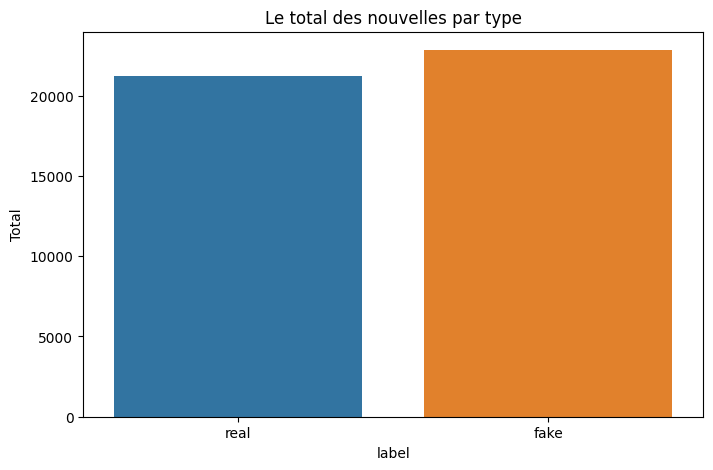

In [78]:
plt.figure(figsize=(8,5))

sb.countplot(data=data,x="label")
plt.title('Le total des nouvelles par type')
plt.ylabel('Total')
plt.xlabel('label')

plt.show()

**-->    51.86 % des exemples sont faux et 48.14 % sont vrai**

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44062 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44062 non-null  object
 1   text     44062 non-null  object
 2   subject  44062 non-null  object
 3   date     44062 non-null  object
 4   label    44062 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [80]:
data.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

**Pas de valeurs manquantes dans notre dataset**

In [81]:
#Le total des articles par subject
data["subject"].value_counts()

politicsNews       11219
worldnews           9991
News                9050
politics            6432
left-news           4310
Government News     1499
US_News              783
Middle-east          778
Name: subject, dtype: int64

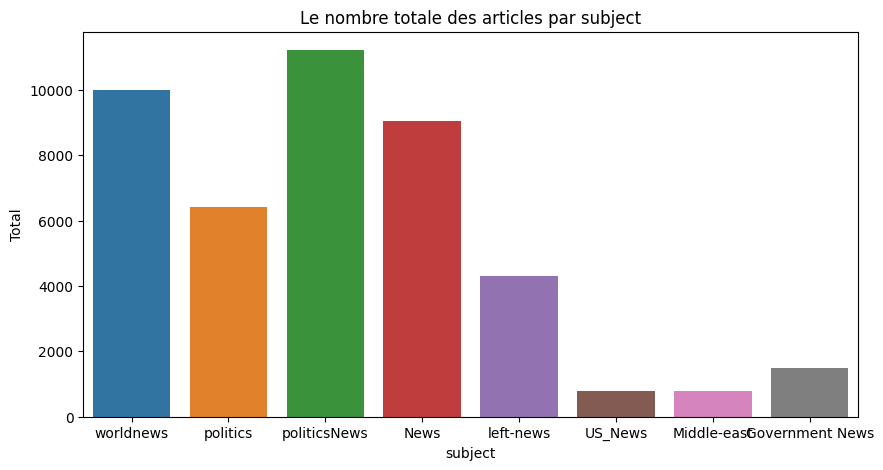

In [82]:
plt.figure(figsize=(10,5))
sb.countplot(x="subject",data=data)
plt.title('Le nombre totale des articles par subject')
plt.ylabel('Total')
plt.xlabel('subject')
plt.show()

####On remarque que les nouvelles de types politicsNews sont les plus frequents dans notre dataset

In [83]:
#Les subjects des articles par type
data.groupby(["label","subject"]).count()["text"]

label  subject        
fake   Government News     1499
       Middle-east          778
       News                9050
       US_News              783
       left-news           4310
       politics            6432
real   politicsNews       11219
       worldnews           9991
Name: text, dtype: int64

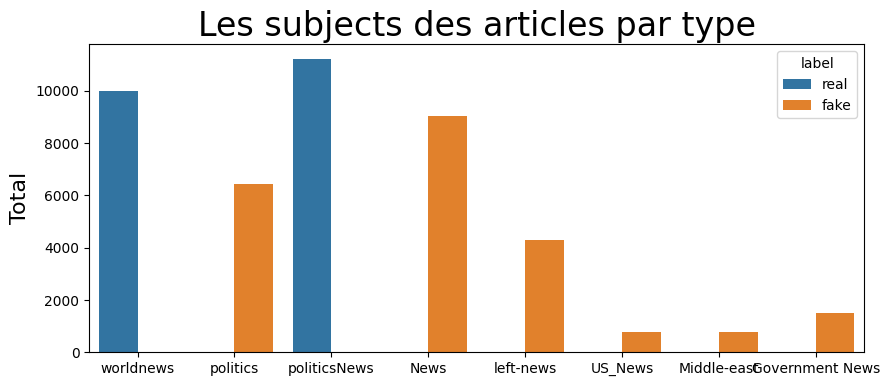

In [84]:
plt.figure(figsize=(10,4))
sb.countplot(x="subject",hue="label",data=data)
plt.title('Les subjects des articles par type', fontsize=24)
plt.ylabel('Total', fontsize=16)
plt.xlabel('')
plt.show()


  > **On remarque que les nouvelles qui sont de types: worldnewset politicsNews sont des vraise nouvelles, à l'opposé celles qui sont de types: left-news, politics, News, US_News, Middle-east et Government News sont des fausses nouvelles.**


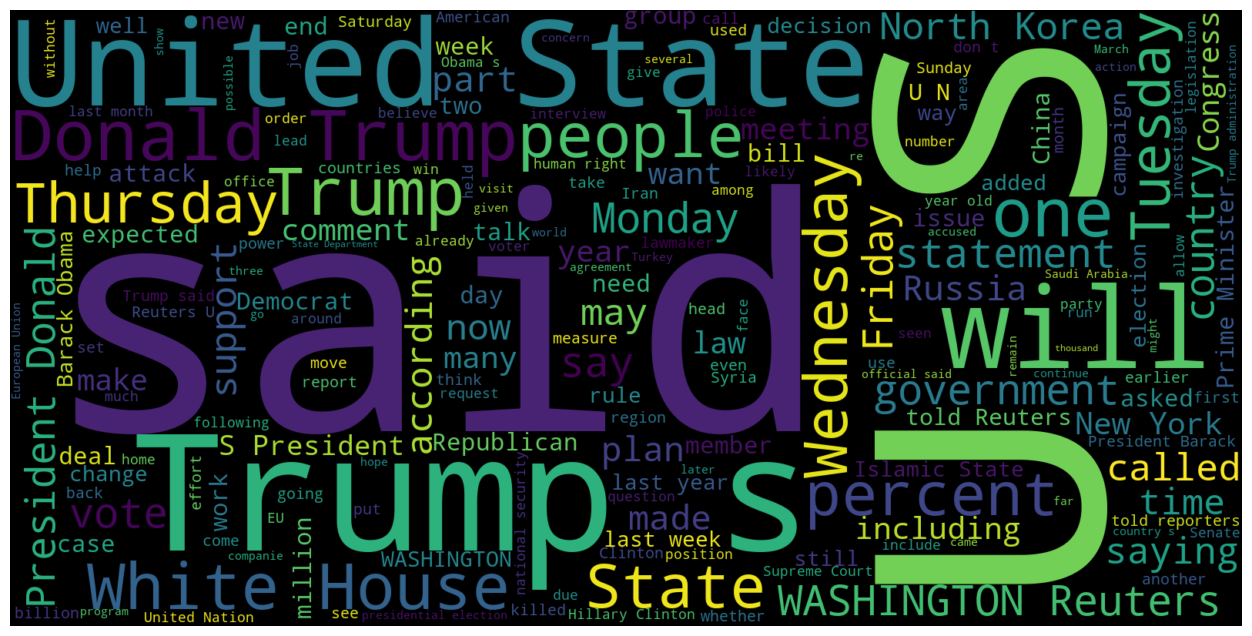

In [85]:
# Text from the real news articles
plt.figure(figsize = (16,8)) 
wc = WordCloud(max_words = 200 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data["label"] == "real"].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

**La pluspart des mots existantes dans les fausses nouvelles sont autour de US , Trump et white house**

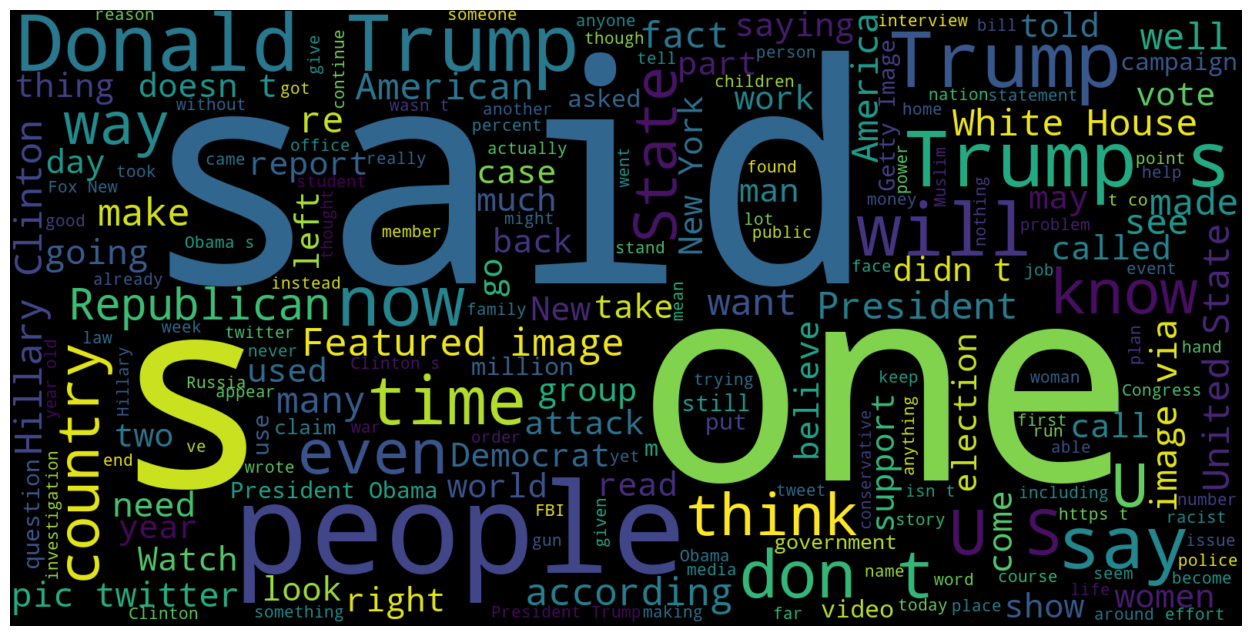

In [86]:
# Text from the real news articles
plt.figure(figsize = (16,8)) 
wc = WordCloud(max_words = 200 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data["label"] == "fake"].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

##**--> traitement des dates**

In [87]:
#Les differents date
data["date"].unique()

array(['December 12, 2017 ', 'Mar 24, 2017', 'November 22, 2017 ', ...,
       'October 9, 2017', 'September 11, 2016 ', 'May 30, 2016 '],
      dtype=object)

In [88]:
#Le nombre d'ocurence de chaque date dans notre dataset
data["date"].value_counts()

December 6, 2017       166
November 30, 2017      160
November 9, 2017       158
October 13, 2017       153
September 21, 2017     153
                      ... 
May 22, 2016             1
November 12, 2017        1
December 30, 2017        1
May 14, 2016             1
May 30, 2016             1
Name: date, Length: 2397, dtype: int64

In [89]:
data["date"].head()

0    December 12, 2017 
2          Mar 24, 2017
3    November 22, 2017 
4     December 4, 2017 
5         July 10, 2017
Name: date, dtype: object

In [90]:
#Les differents date sont separes par des virgules
data.loc[data["date"].str.contains(",")]["date"]

0        December 12, 2017 
2              Mar 24, 2017
3        November 22, 2017 
4         December 4, 2017 
5             July 10, 2017
                ...        
44893     February 8, 2016 
44894           May 8, 2017
44895           Sep 2, 2016
44896          Aug 11, 2017
44897           Oct 5, 2015
Name: date, Length: 44017, dtype: object

In [91]:
#Les autres format de la dates existant dans notre dataset
data.loc[~data["date"].str.contains(",")]["date"]

1159     https://fedup.wpengine.com/wp-content/uploads/...
1317                                             16-Feb-18
1493                                             16-Feb-18
1938                                             17-Feb-18
1973                                             17-Feb-18
2179                                             15-Feb-18
2618                                             15-Feb-18
3260                                             15-Feb-18
4229     https://100percentfedup.com/served-roy-moore-v...
5126                                             16-Feb-18
5158                                             15-Feb-18
6405                                             16-Feb-18
6681     MSNBC HOST Rudely Assumes Steel Worker Would N...
9191                                             17-Feb-18
9676                                             18-Feb-18
11262    https://100percentfedup.com/video-hillary-aske...
14450                                            15-Feb-

In [92]:
#Les index des exemples contenant des liens dans la colonnes date
index_to_drop=data.loc[data["date"].str.contains("https")]["date"].index.to_list()
#L'index de l'exemple contenat un text dans la colonne des dates
except_index=6681

#ajoutant le dernier index à la liste des index á supprimer
index_to_drop.append(except_index)

data.drop(index_to_drop,axis=0,inplace=True)

In [93]:
data.loc[~data["date"].str.contains(",")]["date"]

1317     16-Feb-18
1493     16-Feb-18
1938     17-Feb-18
1973     17-Feb-18
2179     15-Feb-18
2618     15-Feb-18
3260     15-Feb-18
5126     16-Feb-18
5158     15-Feb-18
6405     16-Feb-18
9191     17-Feb-18
9676     18-Feb-18
14450    15-Feb-18
15376    15-Feb-18
15766    16-Feb-18
16517    19-Feb-18
17335    18-Feb-18
18341    18-Feb-18
19165    19-Feb-18
19746    15-Feb-18
20054    17-Feb-18
22889    16-Feb-18
27596    18-Feb-18
28553    18-Feb-18
32364    16-Feb-18
32673    17-Feb-18
33399    18-Feb-18
37249    17-Feb-18
37385    17-Feb-18
38286    14-Feb-18
38975    19-Feb-18
39595    15-Feb-18
39839    18-Feb-18
42042    16-Feb-18
42923    15-Feb-18
Name: date, dtype: object

In [94]:
data.reset_index(drop=True,inplace=True)

In [95]:
#rendre les dates di meme format
data["date"]=pd.to_datetime(data["date"],infer_datetime_format=True)

#extraction des jours, des mois et des années
data["Day"]=data["date"].dt.day
data["Month"]=data["date"].dt.month
data["Year"]=data["date"].dt.year

#suppression de la colonne des dates
data.drop("date",inplace=True,axis=1)

In [96]:
data.loc[:,["Day","Month","Year"]]

,Day,Month,Year
0,12,12,2017
1,24,3,2017
2,22,11,2017
3,4,12,2017
4,10,7,2017
...,...,...,...
44047,8,2,2016
44048,8,5,2017
44049,2,9,2016
44050,11,8,2017


In [97]:
#Le nombre des nouvelles par mois
data.groupby(["Month","label"]).count()["text"]

Month  label
1      fake     2033
       real      996
2      fake     1878
       real     1017
3      fake     2044
       real     1168
4      fake     2082
       real      911
5      fake     2138
       real      898
6      fake     1914
       real      972
7      fake     1949
       real      875
8      fake     1905
       real      916
9      fake     1728
       real     3412
10     fake     1893
       real     3491
11     fake     1695
       real     3716
12     fake     1583
       real     2838
Name: text, dtype: int64

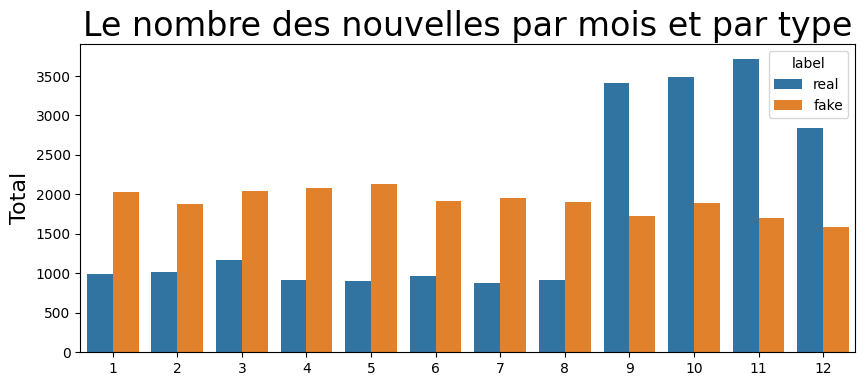

In [98]:
plt.figure(figsize=(10,4))
sb.countplot(x="Month",hue="label",data=data)
plt.title('Le nombre des nouvelles par mois et par type', fontsize=24)
plt.ylabel('Total', fontsize=16)
plt.xlabel('')
plt.show()

**--> On remarque la pluspart des nouvelles sont de type fausses nouvelles pendant toute l'années except les mois [9-12]**

In [99]:
commun_year=[2016,2017]
df=data.loc[data.Year.isin(commun_year)].groupby(by=["Year","Month","label"],as_index=False).count()
df=df.rename(columns={"text":"count"})
df=df.loc[:,["Year","Month","label","count"]]

In [100]:
df["Month"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

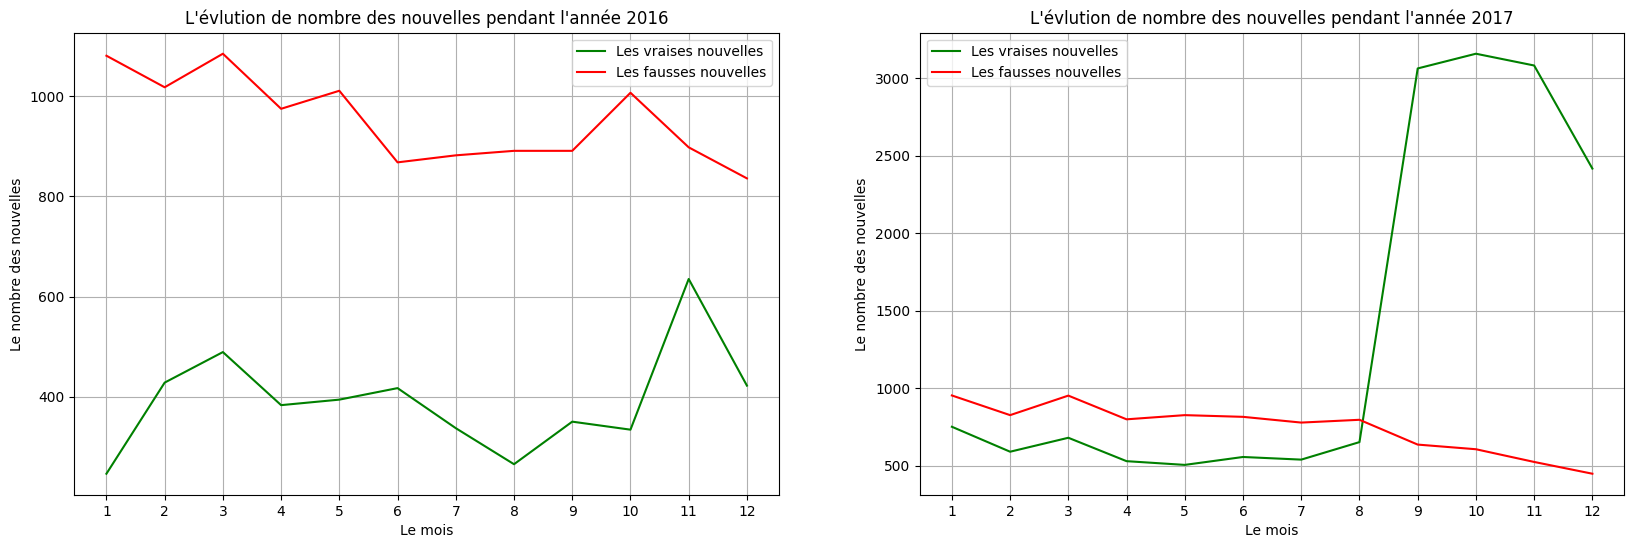

In [101]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(df.loc[(df.label=="real") & (df.Year==2016)]["Month"].to_list(),df.loc[(df.label=="real") & (df.Year==2016)]["count"].to_list(),"g",label="Les vraises nouvelles")
plt.plot(df.loc[(df.label=="fake") & (df.Year==2016)]["Month"].to_list(),df.loc[(df.label=="fake") & (df.Year==2016)]["count"].to_list(),"r",label="Les fausses nouvelles")
plt.title("L'évlution de nombre des nouvelles pendant l'année 2016")

plt.grid()
plt.legend()
plt.xlabel("Le mois")
plt.ylabel("Le nombre des nouvelles")
plt.xticks(df["Month"].unique())
 
plt.subplot(1,2,2)
plt.plot(df.loc[(df.label=="real") & (df.Year==2017)]["Month"].to_list(),df.loc[(df.label=="real") & (df.Year==2017)]["count"].to_list(),"g",label="Les vraises nouvelles")
plt.plot(df.loc[(df.label=="fake") & (df.Year==2017)]["Month"].to_list(),df.loc[(df.label=="fake") & (df.Year==2017)]["count"].to_list(),"r",label="Les fausses nouvelles")
plt.title("L'évlution de nombre des nouvelles pendant l'année 2017")

plt.grid()
plt.legend()
plt.xlabel("Le mois")
plt.ylabel("Le nombre des nouvelles")
plt.xticks(df["Month"].unique())
plt.show()

In [102]:
#la distribution des nouvelles pendant le début d'avril
vd=data.loc[(data.Day==1) & (data.Month==4)].groupby(by=["label"],as_index=False).count()[["label","text"]]
vd=vd.rename(columns={"text":"count"})
vd

,label,count
0,fake,64
1,real,16


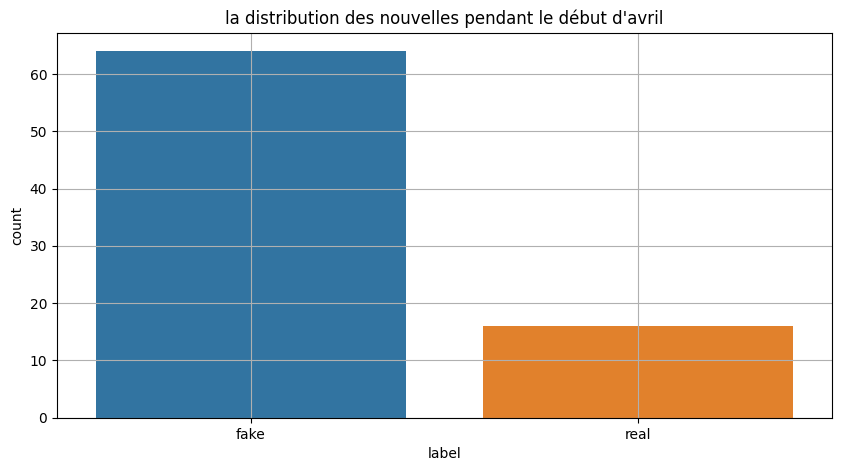

In [132]:
#visualisation
plt.figure(figsize=(10,5))
sb.barplot(data=vd,x="label",y="count")
plt.grid()
plt.title("la distribution des nouvelles pendant le début d'avril")
plt.show()

**--> on remarque que 80% des nouvelles sont fausses dans les jours 1 avril pour toutes les anneées existantes dans notre dataset*

In [104]:
data.head()

,title,text,subject,label,Day,Month,Year
0,China warns against livestreaming after 'rooft...,BEIJING (Reuters) - A young Chinese climbing e...,worldnews,real,12,12,2017
1,BREAKING: GANG THAT CAN’T SHOOT STRAIGHT: Vote...,Speaker Ryan: We were on the cusp of achievin...,politics,fake,24,3,2017
2,"Arab states blacklist Islamist groups, individ...",DUBAI (Reuters) - The four Arab countries boyc...,worldnews,real,22,11,2017
3,"Democrats to join Trump, Republicans in talks ...",WASHINGTON (Reuters) - Democratic leaders in C...,politicsNews,real,4,12,2017
4,Trump Has Complete Meltdown And Attacks Chels...,Donald Trump threw an early morning temper tan...,News,fake,10,7,2017


##preparing the dataset for ML

In [105]:
#removing the unusual columns in the dataset
data.drop(["Day","Month","Year"],axis=1,inplace=True)

#converting the label column values real:0 and fake:1
data["label"]=data["label"].replace(["real","fake"],[0,1])

#converting the subject column from categories into numbers
subject_categories=sorted(data["subject"].unique()) #to get the unique value in the subject serie
data["subject"]=data["subject"].replace( subject_categories,list( range(1,len(subject_categories)+1) ) )

In [106]:
df_file=data.loc[:,["title","text","label"]]

In [107]:
""" df_file["label"]=df_file["label"].replace([0,1],["Real","Fake"])
df_file=df_file.sample(n=100)
df_file.reset_index(drop=True,inplace=True)
df_file.to_csv("articles_exemples_fake_real_news.csv") """

' df_file["label"]=df_file["label"].replace([0,1],["Real","Fake"])\ndf_file=df_file.sample(n=100)\ndf_file.reset_index(drop=True,inplace=True)\ndf_file.to_csv("articles_exemples_fake_real_news.csv") '

In [108]:
""" df_file.label.value_counts() """

' df_file.label.value_counts() '

>*Joining the title and the text in one columns with name article_content*

In [109]:
#rejoindre le titre et le texte dans une seule colonne
data["article_content"]=data["title"]+" "+data["text"]

#suppression des colonnes title et text
data.drop(["title","text"],axis=1,inplace=True)

In [110]:
data.head()

,subject,label,article_content
0,8,0,China warns against livestreaming after 'rooft...
1,6,1,BREAKING: GANG THAT CAN’T SHOOT STRAIGHT: Vote...
2,8,0,"Arab states blacklist Islamist groups, individ..."
3,7,0,"Democrats to join Trump, Republicans in talks ..."
4,3,1,Trump Has Complete Meltdown And Attacks Chels...


####Applying NLP techniques

**The main functions**

In [111]:
#stopward set
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:
#les punctuations
punctuations=list(string.punctuation)
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [113]:
#remove extra white spaces
def remove_extra_spaces(text):
  return str(text).strip()

#lower case
def lower_case(text):
  return text.lower()

In [ ]:
nltk.download('tagsets')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [114]:
#punctuation removal
def remove_punctuation(text):
  text="".join(car for car in text if car not in punctuations)
  return str(text)

#removing the urls
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

# Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip())
    return " ".join(final_text)

#applying the pos tagging for part-of-speech
def pos_tagging(text):
  # Tokenize the article
  tokens = nltk.word_tokenize(text)

  # Perform part-of-speech tagging
  pos_tags = nltk.pos_tag(tokens)
  text=""
  for token, pos in pos_tags:
    text+=token+"-"+pos+" "
  return str(text)

#clean text function
def text_cleaned(text):
  text=remove_urls(text)
  text=remove_stopwords(text)
  text=remove_punctuation(text)
  text=pos_tagging(text)
  text=remove_extra_spaces(text)
  text=lower_case(text)
  return text

In [ ]:
#l'ensemble des tag_set
nltk.help.brown_tagset()

-->application of NLP technics for the variables "title, text,"

In [115]:
data["article_content"]=data["article_content"].apply(text_cleaned)

In [116]:
data.head()

,subject,label,article_content
0,8,0,china warns livestreaming 'rooftopper' falls d...
1,6,1,breaking: gang can’t shoot straight: vote canc...
2,8,0,"arab states blacklist islamist groups, individ..."
3,7,0,"democrats join trump, republicans talks avert ..."
4,3,1,trump complete meltdown attacks chelsea clinto...


####Maching Learning

In [117]:
#the features vector
X = data["article_content"]

#the target variable
Y = data["label"]



In [118]:
%%time
# Create a Count Vectorize object to transform our text data into numerical data
cv=CountVectorizer()

# Transform the train dataset
X=cv.fit_transform(X)

print(f"the new shape of X is: {X.shape}")

#saving the vectorise into memory
print("\nSaving the vectorizer into memory ...\n")
pickle.dump(cv,open("vectorizer.pkl",'wb'))
print("\nSaving done !\n")

the new shape of X is: (44052, 118751)

Saving the vectorizer into memory ...


Saving done !

CPU times: total: 8.31 s
Wall time: 9.6 s


In [119]:
print(X.shape)

(44052, 118751)


In [120]:
#concatinating the subject feature with the X variable
#X=pd.concat([X.toarray(),data.subject],axis=1)

In [121]:
#spliting the data into train and test with 20% of testing data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2,stratify=Y, random_state=19)

##*Maching learning models*
>we have 10 maching learning models to test and to compare: Multinomial Naive Bayes, Passive Agressive Classifier and the listed models below in the picture:

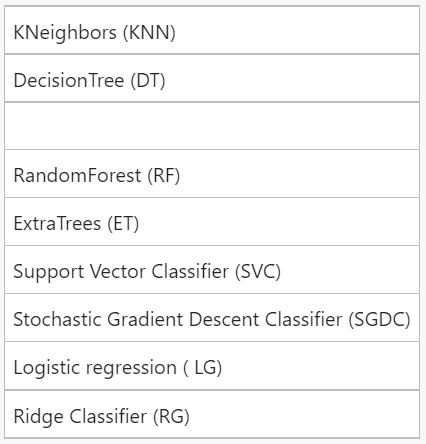

#model1

In [122]:
%%time
#Create and build our model
model1=MultinomialNB()  #Naive Bayes Classifier
print(f"\nThe model:\t{model1.__class__.__name__}")
# Fit the model to the Bag of words CountVectorizor
print("\nModel fitting ...\n")
model1.fit(x_train, y_train)

#the prediction data of CountVectorizor
print("\nMaking prediction ...\n")
cv_predicted_data=model1.predict(x_test)

#the accuracy score of the model fitted with CountVectorizor
print("\nCalculating the accuracy score ...\n")
cv_accuracy=accuracy_score(cv_predicted_data,y_test)
print(f"\nthe accuracy score of the model is: {round(cv_accuracy*100,4)}% .")

#the confusion matrix of the model fitted with CountVectorizor
cv_confusion_matrix=confusion_matrix(cv_predicted_data,y_test)
print(f"\nthe confusion matrix of the model is:\n\n{cv_confusion_matrix}")

#the classification report of the model fitted with CountVectorizor
cv_classification_report=classification_report(cv_predicted_data,y_test)
print(f"\nthe classification report of the model is:\n\n{cv_classification_report}")


The model:	MultinomialNB

Model fitting ...


Making prediction ...


Calculating the accuracy score ...


the accuracy score of the model is: 95.3808% .

the confusion matrix of the model is:

[[4026  191]
 [ 216 4378]]

the classification report of the model is:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4217
           1       0.96      0.95      0.96      4594

    accuracy                           0.95      8811
   macro avg       0.95      0.95      0.95      8811
weighted avg       0.95      0.95      0.95      8811

CPU times: total: 46.9 ms
Wall time: 75.4 ms


#model2

In [123]:
%%time
#Create and build our model
model2=PassiveAggressiveClassifier(random_state=13)  # the passive agressive classifier
print(f"\nThe model:\t{model2.__class__.__name__}")
# Fit the model to the Bag of words CountVectorizor
print("\nModel fitting ...\n")
model2.fit(x_train, y_train)

#the prediction data of CountVectorizor
print("\nMaking prediction ...\n")
cv_predicted_data=model2.predict(x_test)

#the accuracy score of the model fitted with CountVectorizor
print("\nCalculating the accuracy score ...\n")
cv_accuracy=accuracy_score(cv_predicted_data,y_test)
print(f"\nthe accuracy score of the model is: {round(cv_accuracy*100,4)}% .")

#the confusion matrix of the model fitted with CountVectorizor
cv_confusion_matrix=confusion_matrix(cv_predicted_data,y_test)
print(f"\nthe confusion matrix of the model is:\n\n{cv_confusion_matrix}")

#the classification report of the model fitted with CountVectorizor
cv_classification_report=classification_report(cv_predicted_data,y_test)
print(f"\nthe classification report of the model is:\n\n{cv_classification_report}")


The model:	PassiveAggressiveClassifier

Model fitting ...


Making prediction ...


Calculating the accuracy score ...


the accuracy score of the model is: 99.5687% .

the confusion matrix of the model is:

[[4225   21]
 [  17 4548]]

the classification report of the model is:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4246
           1       1.00      1.00      1.00      4565

    accuracy                           1.00      8811
   macro avg       1.00      1.00      1.00      8811
weighted avg       1.00      1.00      1.00      8811

CPU times: total: 484 ms
Wall time: 626 ms


#model3

In [124]:
%%time
#Create and build our model
model3=KNeighborsClassifier(n_neighbors=7) #the KNN Classifier

print(f"\nThe model:\t{model3.__class__.__name__}")
# Fit the model to the Bag of words CountVectorizor
print("\nModel fitting ...\n")
model3.fit(x_train, y_train)

#the prediction data of CountVectorizor
print("\nMaking prediction ...\n")
cv_predicted_data=model3.predict(x_test)

#the accuracy score of the model fitted with CountVectorizor
print("\nCalculating the accuracy score ...\n")
cv_accuracy=accuracy_score(cv_predicted_data,y_test)
print(f"\nthe accuracy score of the model is: {round(cv_accuracy*100,4)}% .")

#the confusion matrix of the model fitted with CountVectorizor
cv_confusion_matrix=confusion_matrix(cv_predicted_data,y_test)
print(f"\nthe confusion matrix of the model is:\n\n{cv_confusion_matrix}")

#the classification report of the model fitted with CountVectorizor
cv_classification_report=classification_report(cv_predicted_data,y_test)
print(f"\nthe classification report of the model is:\n\n{cv_classification_report}")


The model:	KNeighborsClassifier

Model fitting ...


Making prediction ...


Calculating the accuracy score ...


the accuracy score of the model is: 78.9922% .

the confusion matrix of the model is:

[[3187  796]
 [1055 3773]]

the classification report of the model is:

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      3983
           1       0.83      0.78      0.80      4828

    accuracy                           0.79      8811
   macro avg       0.79      0.79      0.79      8811
weighted avg       0.79      0.79      0.79      8811

CPU times: total: 23.8 s
Wall time: 26.1 s


#model4

In [125]:
%%time
#Create and build our model
model4=DecisionTreeClassifier(random_state=111) #the decision tree classifier

print(f"\nThe model:\t{model4.__class__.__name__}")
# Fit the model to the Bag of words CountVectorizor
print("\nModel fitting ...\n")
model4.fit(x_train, y_train)

#the prediction data of CountVectorizor
print("\nMaking prediction ...\n")
cv_predicted_data=model4.predict(x_test)

#the accuracy score of the model fitted with CountVectorizor
print("\nCalculating the accuracy score ...\n")
cv_accuracy=accuracy_score(cv_predicted_data,y_test)
print(f"\nthe accuracy score of the model is: {round(cv_accuracy*100,4)}% .")

#the confusion matrix of the model fitted with CountVectorizor
cv_confusion_matrix=confusion_matrix(cv_predicted_data,y_test)
print(f"\nthe confusion matrix of the model is:\n\n{cv_confusion_matrix}")

#the classification report of the model fitted with CountVectorizor
cv_classification_report=classification_report(cv_predicted_data,y_test)
print(f"\nthe classification report of the model is:\n\n{cv_classification_report}")

#saving the model into a pkl file
print("\nSaving the model into memory ...\n")
pickle.dump(model4,open("DT_model.pkl",'wb'))
print("\nDone !\n")


The model:	DecisionTreeClassifier

Model fitting ...


Making prediction ...


Calculating the accuracy score ...


the accuracy score of the model is: 99.7276% .

the confusion matrix of the model is:

[[4228   10]
 [  14 4559]]

the classification report of the model is:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4238
           1       1.00      1.00      1.00      4573

    accuracy                           1.00      8811
   macro avg       1.00      1.00      1.00      8811
weighted avg       1.00      1.00      1.00      8811


Saving the model into memory ...


Done !

CPU times: total: 17.5 s
Wall time: 18.3 s


#model5

In [126]:
%%time
#Create and build our model
model5=RandomForestClassifier(random_state=143) #the random forest classifier

print(f"\nThe model:\t{model5.__class__.__name__}")
# Fit the model to the Bag of words CountVectorizor
print("\nModel fitting ...\n")
model5.fit(x_train, y_train)

#the prediction data of CountVectorizor
print("\nMaking prediction ...\n")
cv_predicted_data=model5.predict(x_test)

#the accuracy score of the model fitted with CountVectorizor
print("\nCalculating the accuracy score ...\n")
cv_accuracy=accuracy_score(cv_predicted_data,y_test)
print(f"\nthe accuracy score of the model is: {round(cv_accuracy*100,4)}% .")

#the confusion matrix of the model fitted with CountVectorizor
cv_confusion_matrix=confusion_matrix(cv_predicted_data,y_test)
print(f"\nthe confusion matrix of the model is:\n\n{cv_confusion_matrix}")

#the classification report of the model fitted with CountVectorizor
cv_classification_report=classification_report(cv_predicted_data,y_test)
print(f"\nthe classification report of the model is:\n\n{cv_classification_report}")


The model:	RandomForestClassifier

Model fitting ...


Making prediction ...


Calculating the accuracy score ...


the accuracy score of the model is: 99.3304% .

the confusion matrix of the model is:

[[4217   34]
 [  25 4535]]

the classification report of the model is:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4251
           1       0.99      0.99      0.99      4560

    accuracy                           0.99      8811
   macro avg       0.99      0.99      0.99      8811
weighted avg       0.99      0.99      0.99      8811

CPU times: total: 3min 15s
Wall time: 3min 23s


#model6

In [127]:
%%time
#Create and build our model
model6=ExtraTreesClassifier(random_state=37) #the Extra tree classifier

print(f"\nThe model:\t{model6.__class__.__name__}")
# Fit the model to the Bag of words CountVectorizor
print("\nModel fitting ...\n")
model6.fit(x_train, y_train)

#the prediction data of CountVectorizor
print("\nMaking prediction ...\n")
cv_predicted_data=model6.predict(x_test)

#the accuracy score of the model fitted with CountVectorizor
print("\nCalculating the accuracy score ...\n")
cv_accuracy=accuracy_score(cv_predicted_data,y_test)
print(f"\nthe accuracy score of the model is: {round(cv_accuracy*100,4)}% .")

#the confusion matrix of the model fitted with CountVectorizor
cv_confusion_matrix=confusion_matrix(cv_predicted_data,y_test)
print(f"\nthe confusion matrix of the model is:\n\n{cv_confusion_matrix}")

#the classification report of the model fitted with CountVectorizor
cv_classification_report=classification_report(cv_predicted_data,y_test)
print(f"\nthe classification report of the model is:\n\n{cv_classification_report}")


The model:	ExtraTreesClassifier

Model fitting ...


Making prediction ...


Calculating the accuracy score ...


the accuracy score of the model is: 98.6835% .

the confusion matrix of the model is:

[[4188   62]
 [  54 4507]]

the classification report of the model is:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4250
           1       0.99      0.99      0.99      4561

    accuracy                           0.99      8811
   macro avg       0.99      0.99      0.99      8811
weighted avg       0.99      0.99      0.99      8811

CPU times: total: 6min 23s
Wall time: 6min 46s


#model7

In [128]:
%%time
#Create and build our model
model7=SVC(kernel="linear")  #the support vector machine classifier

print(f"\nThe model:\t{model7.__class__.__name__}")
# Fit the model to the Bag of words CountVectorizor
print("\nModel fitting ...\n")
model7.fit(x_train, y_train)

#the prediction data of CountVectorizor
print("\nMaking prediction ...\n")
cv_predicted_data=model7.predict(x_test)

#the accuracy score of the model fitted with CountVectorizor
print("\nCalculating the accuracy score ...\n")
cv_accuracy=accuracy_score(cv_predicted_data,y_test)
print(f"\nthe accuracy score of the model is: {round(cv_accuracy*100,4)}% .")

#the confusion matrix of the model fitted with CountVectorizor
cv_confusion_matrix=confusion_matrix(cv_predicted_data,y_test)
print(f"\nthe confusion matrix of the model is:\n\n{cv_confusion_matrix}")

#the classification report of the model fitted with CountVectorizor
cv_classification_report=classification_report(cv_predicted_data,y_test)
print(f"\nthe classification report of the model is:\n\n{cv_classification_report}")


The model:	SVC

Model fitting ...


Making prediction ...


Calculating the accuracy score ...


the accuracy score of the model is: 99.7049% .

the confusion matrix of the model is:

[[4229   13]
 [  13 4556]]

the classification report of the model is:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4242
           1       1.00      1.00      1.00      4569

    accuracy                           1.00      8811
   macro avg       1.00      1.00      1.00      8811
weighted avg       1.00      1.00      1.00      8811

CPU times: total: 3min 30s
Wall time: 3min 37s


#model8

In [129]:
%%time
#Create and build our model
model8=SGDClassifier(random_state=29)  #the Stochastic Gradient Descent Classifier

print(f"\nThe model:\t{model8.__class__.__name__}")
# Fit the model to the Bag of words CountVectorizor
print("\nModel fitting ...\n")
model8.fit(x_train, y_train)

#the prediction data of CountVectorizor
print("\nMaking prediction ...\n")
cv_predicted_data=model8.predict(x_test)

#the accuracy score of the model fitted with CountVectorizor
print("\nCalculating the accuracy score ...\n")
cv_accuracy=accuracy_score(cv_predicted_data,y_test)
print(f"\nthe accuracy score of the model is: {round(cv_accuracy*100,4)}% .")

#the confusion matrix of the model fitted with CountVectorizor
cv_confusion_matrix=confusion_matrix(cv_predicted_data,y_test)
print(f"\nthe confusion matrix of the model is:\n\n{cv_confusion_matrix}")

#the classification report of the model fitted with CountVectorizor
cv_classification_report=classification_report(cv_predicted_data,y_test)
print(f"\nthe classification report of the model is:\n\n{cv_classification_report}")


The model:	SGDClassifier

Model fitting ...


Making prediction ...


Calculating the accuracy score ...


the accuracy score of the model is: 99.512% .

the confusion matrix of the model is:

[[4216   17]
 [  26 4552]]

the classification report of the model is:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4233
           1       1.00      0.99      1.00      4578

    accuracy                           1.00      8811
   macro avg       1.00      1.00      1.00      8811
weighted avg       1.00      1.00      1.00      8811

CPU times: total: 234 ms
Wall time: 282 ms


#model9

In [130]:
%%time
#Create and build our model
model9=LogisticRegression(random_state=87) #the Logistic regression classifier

print(f"\nThe model:\t{model9.__class__.__name__}")
# Fit the model to the Bag of words CountVectorizor
print("\nModel fitting ...\n")
model9.fit(x_train, y_train)

#the prediction data of CountVectorizor
print("\nMaking prediction ...\n")
cv_predicted_data=model9.predict(x_test)

#the accuracy score of the model fitted with CountVectorizor
print("\nCalculating the accuracy score ...\n")
cv_accuracy=accuracy_score(cv_predicted_data,y_test)
print(f"\nthe accuracy score of the model is: {round(cv_accuracy*100,4)}% .")

#the confusion matrix of the model fitted with CountVectorizor
cv_confusion_matrix=confusion_matrix(cv_predicted_data,y_test)
print(f"\nthe confusion matrix of the model is:\n\n{cv_confusion_matrix}")

#the classification report of the model fitted with CountVectorizor
cv_classification_report=classification_report(cv_predicted_data,y_test)
print(f"\nthe classification report of the model is:\n\n{cv_classification_report}")


The model:	LogisticRegression

Model fitting ...


Making prediction ...


Calculating the accuracy score ...


the accuracy score of the model is: 99.7049% .

the confusion matrix of the model is:

[[4231   15]
 [  11 4554]]

the classification report of the model is:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4246
           1       1.00      1.00      1.00      4565

    accuracy                           1.00      8811
   macro avg       1.00      1.00      1.00      8811
weighted avg       1.00      1.00      1.00      8811

CPU times: total: 781 ms
Wall time: 4.79 s


c:\Users\User1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#model10

In [131]:
%%time
#Create and build our model
model10=RidgeClassifier(random_state=73) #the Ridge Classifier

print(f"\nThe model:\t{model10.__class__.__name__}")
# Fit the model to the Bag of words CountVectorizor
print("\nModel fitting ...\n")
model10.fit(x_train, y_train)

#the prediction data of CountVectorizor
print("\nMaking prediction ...\n")
cv_predicted_data=model10.predict(x_test)

#the accuracy score of the model fitted with CountVectorizor
print("\nCalculating the accuracy score ...\n")
cv_accuracy=accuracy_score(cv_predicted_data,y_test)
print(f"\nthe accuracy score of the model is: {round(cv_accuracy*100,4)}% .")

#the confusion matrix of the model fitted with CountVectorizor
cv_confusion_matrix=confusion_matrix(cv_predicted_data,y_test)
print(f"\nthe confusion matrix of the model is:\n\n{cv_confusion_matrix}")

#the classification report of the model fitted with CountVectorizor
cv_classification_report=classification_report(cv_predicted_data,y_test)
print(f"\nthe classification report of the model is:\n\n{cv_classification_report}")


The model:	RidgeClassifier

Model fitting ...


Making prediction ...


Calculating the accuracy score ...


the accuracy score of the model is: 94.9722% .

the confusion matrix of the model is:

[[4000  201]
 [ 242 4368]]

the classification report of the model is:

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      4201
           1       0.96      0.95      0.95      4610

    accuracy                           0.95      8811
   macro avg       0.95      0.95      0.95      8811
weighted avg       0.95      0.95      0.95      8811

CPU times: total: 3.94 s
Wall time: 47.5 s



* Model_name					------> 		accuracy	, time

* MultinomialNB 					------>		95.38% 	, 82.8 ms
* PassiveAggressiveClassifier 		------>		99.57% 	, 613 ms
* KNeighborsClassifier 			------>		78.99% 	, 23.9 s
* DecisionTreeClassifier			------>		99.73% 	, 11.3s
* RandomForestClassifier 			------>		99.33% 	, 1min 40s
* ExtraTreesClassifier 			------>		98.68% 	, 3min17s
* SVC 						------>		99.70% 	, 3min46s
* SGDClassifier 					------>		99.51% 	, 436ms
* LogisticRegression 				------>		99.70% 	, 12.9ms
* RidgeClassifier 				------>		94.96% 	, 2min 36s

> **For deployment we're going to try the Decision Tree Classifier which gives us the best accuracy**